In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf

In [2]:
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

In [3]:
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)
    mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
    sort_by_target(mnist) # fetch_openml() returns an unsorted dataset
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')
mnist["data"], mnist["target"]

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0, 0, 0, ..., 9, 9, 9], dtype=int8))

In [4]:
mnist.data.shape

(70000, 784)

In [5]:
X ,y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


In [6]:
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)

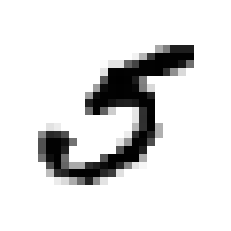

In [7]:
# plot the first image
plt.imshow(some_digit_image, cmap='binary', interpolation='nearest')
plt.axis('off')
plt.show()

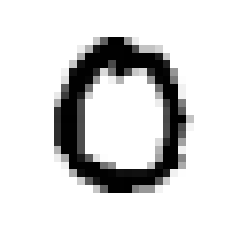

In [8]:
plt.imshow(X[3600].reshape(28,28), cmap='binary', interpolation='nearest')
plt.axis('off')
plt.show()


In [9]:
# splitting the  data into train and  test set
X_train , X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [10]:
# shuffling the dataset
shuffle_index = np.random.permutation(60000)
x_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

### Training a binary classifier

In [11]:
# creating a 5-detector 
y_train_5 = (y_train == 5)
y_test_5 =  (y_test ==5)

In [12]:
# flattening the dataset from a 3-D to a 2-D 
# X_train_2d = X_train.reshape(X_train.shape[0], -1)
# X_test_2d = X_test.reshape(X_test.shape[0], -1)

In [13]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=66)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=66)

Stochastic Gradient Descent (SGD) classifier, using Scikit-Learn’s SGDClassifier class. This clas‐ sifier has the advantage of being capable of handling very large datasets efficiently. This is in part because SGD deals with training instances independently, one at a time (which also makes SGD well suited for online learning)

In [14]:
some_digit = X_train[36000]
sgd_clf.predict([some_digit])

array([False])

In [15]:
some_5_digit = X_train[89]
sgd_clf.predict([some_5_digit])

array([False])

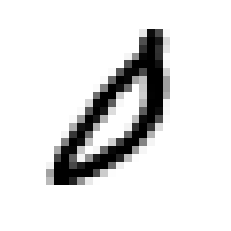

In [16]:
# plotting the image
plt.imshow(X_train[89].reshape(28,28), cmap='binary', interpolation='nearest')
plt.axis('off')
plt.show()

### Implementing the cross-validation from scratch

In [17]:
from sklearn.model_selection import StratifiedKFold 
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)
for train_index, test_index in skfolds.split(X_train, y_train_5): 
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred)) # prints 0.9502, 0.96565 and 0.9649

ValueError: Setting a random_state has no effect since shuffle is False. You should leave random_state to its default (None), or set shuffle=True.

In [ ]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.90485, 0.8859 , 0.8946 ])

In [ ]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass

    def predict(self, X):
        return np.zeros((len(X), 1),dtype=bool)

In [ ]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.9109 , 0.9076 , 0.91045])

That’s right, it has over 90% accuracy! This is simply because only about 10% of the images are 5s, so if you always guess that an image is not a 5, you will be right about 90% of the time. Beats Nostradamus.
This demonstrates why accuracy is generally not the preferred performance measure for classifiers, especially when you are dealing with skewed datasets (i.e., when some classes are much more frequent than others).

In [ ]:
# confusion matrix
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Just like the cross_val_score() function, cross_val_predict() performs K-fold cross-validation, but instead of returning the evaluation scores, it returns the <b style="color:blue;font-size:26px;"> predictions</b> made on each test fold. This means that you get a clean prediction for each instance in the training set (“clean” meaning that the prediction is made by a model that never saw the data during training).

[[53598   981]
 [ 5312   109]]


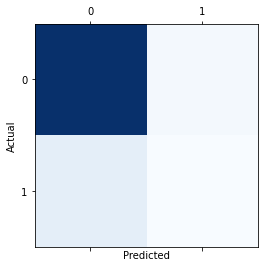

In [ ]:
from sklearn.metrics import confusion_matrix

# confusion matrix with the actual values
print(confusion_matrix(y_train_5, y_train_pred))

plt.matshow(confusion_matrix(y_train_5, y_train_pred), cmap=plt.cm.Blues, interpolation='nearest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Each row in a confusion matrix represents an actual class while the columns represent the predicted columns

In [ ]:
from sklearn.metrics import precision_score, recall_score ,f1_score

print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))
print(f1_score(y_train_5,y_train_pred))


0.1
0.020106991330012914
0.03348180003071725
